In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH
START = '2013-01-01'
END = '2017-12-31'

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [5]:
DATA_STORE = 'C:/Users/86155/Machine Learning for Algorithmic Trading/data/assets.h5'
ohlcv =  ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices'].loc[idx[START:END,:], ohlcv].rename(columns = lambda x: x.replace('adj_','')).swaplevel().sort_index())
    stocks = (store['us_equities/stocks'].loc[:,['marketcap','ipoyear','sector']])

In [6]:
prices

open      close        low       high     volume
ticker date                                                             
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287700.0
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114300.0
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601500.0
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567600.0
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787500.0
...                      ...        ...        ...        ...        ...
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209585.0
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213951.0
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227325.0
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162070.0
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222040.0

[3619403 rows x 5 columns]

In [7]:
min_obs = 2*YEAR
nobs = prices.groupby(level = 'ticker').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep,:],:]

In [8]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

In [9]:
shared = (prices.index.get_level_values('ticker').unique().intersection(stocks.index))
stocks = stocks.loc[shared,:]
prices = prices.loc[idx[shared,:],:]

In [10]:
prices.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2904233 non-null  float64
 1   close   2904233 non-null  float64
 2   low     2904233 non-null  float64
 3   high    2904233 non-null  float64
 4   volume  2904233 non-null  float64
dtypes: float64(5)
memory usage: 122.6+ MB


In [11]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2345 non-null   float64
 1   ipoyear    1026 non-null   float64
 2   sector     2348 non-null   object 
dtypes: float64(2), object(1)
memory usage: 73.4+ KB


In [12]:
stocks.sector.value_counts()

consumer_services        440
finance                  393
technology               297
health_care              297
capital_goods            227
basic_industries         138
consumer_non-durables    126
energy                   123
public_utilities         105
consumer_durables         78
miscellaneous             69
transportation            55
Name: sector, dtype: int64

In [13]:
prices['dollar_vol'] = prices.loc[:,'close'].mul(prices.loc[:,'volume'],axis = 0)
prices['dollar_vol'] = (prices.groupby('ticker',group_keys = False, as_index = False).dollar_vol.rolling(window = 21).mean().fillna(0).reset_index(level = 0, drop = True)).values
prices['dollar_vol_rank'] = prices.groupby('date').dollar_vol.rank(ascending = False)

In [14]:
prices

open      close        low       high     volume  \
ticker date                                                                
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287700.0   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114300.0   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601500.0   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567600.0   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787500.0   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209585.0   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213951.0   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227325.0   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162070.0   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222040.0   

                     dollar_vol  dollar_vol_rank  
ticker date                                       
A      2013-01-02  0.000000e+00           1088.5  
       2013-01-03  0.000000e+00           1088.5  
       2013-01-04  0.000000e+00           1088.5  
       2013-01-07  0.000000e+00           1088.5  
       2013-01-08  0.000000e+00           1088.5  
...                         ...              ...  
ZUMZ   2017-12-22  1.193000e+07           1288.0  
       2017-12-26  1.196337e+07           1291.0  
       2017-12-27  1.178694e+07           1293.0  
       2017-12-28  1.129021e+07           1300.0  
       2017-12-29  1.079061e+07           1312.0  

[2904233 rows x 7 columns]

In [15]:
prices['rsi'] = prices.groupby(level = 'ticker').close.apply(RSI)

In [16]:
prices

open      close        low       high     volume  \
ticker date                                                                
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287700.0   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114300.0   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601500.0   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567600.0   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787500.0   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209585.0   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213951.0   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227325.0   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162070.0   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222040.0   

                     dollar_vol  dollar_vol_rank        rsi  
ticker date                                                  
A      2013-01-02  0.000000e+00           1088.5        NaN  
       2013-01-03  0.000000e+00           1088.5        NaN  
       2013-01-04  0.000000e+00           1088.5        NaN  
       2013-01-07  0.000000e+00           1088.5        NaN  
       2013-01-08  0.000000e+00           1088.5        NaN  
...                         ...              ...        ...  
ZUMZ   2017-12-22  1.193000e+07           1288.0  61.077094  
       2017-12-26  1.196337e+07           1291.0  63.799097  
       2017-12-27  1.178694e+07           1293.0  56.369727  
       2017-12-28  1.129021e+07           1300.0  56.757082  
       2017-12-29  1.079061e+07           1312.0  52.959469  

[2904233 rows x 8 columns]

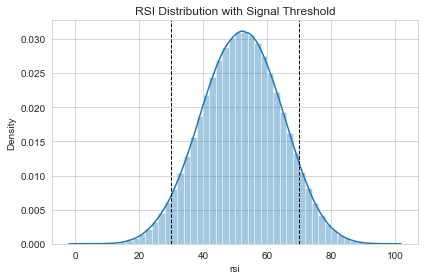

In [17]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls = '--',lw = 1, c = 'k')
ax.axvline(70, ls = '--', lw = 1, c = 'k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()

In [18]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod = 20)
    return pd.DataFrame({'bb_high': high, 'bb_low':low},index = close.index)

In [19]:
prices = prices.join(prices.groupby(level = 'ticker').close.apply(compute_bb))

In [20]:
prices

open      close        low       high     volume  \
ticker date                                                                
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287700.0   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114300.0   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601500.0   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567600.0   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787500.0   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209585.0   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213951.0   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227325.0   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162070.0   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222040.0   

                     dollar_vol  dollar_vol_rank        rsi    bb_high  \
ticker date                                                              
A      2013-01-02  0.000000e+00           1088.5        NaN        NaN   
       2013-01-03  0.000000e+00           1088.5        NaN        NaN   
       2013-01-04  0.000000e+00           1088.5        NaN        NaN   
       2013-01-07  0.000000e+00           1088.5        NaN        NaN   
       2013-01-08  0.000000e+00           1088.5        NaN        NaN   
...                         ...              ...        ...        ...   
ZUMZ   2017-12-22  1.193000e+07           1288.0  61.077094  22.086859   
       2017-12-26  1.196337e+07           1291.0  63.799097  22.073133   
       2017-12-27  1.178694e+07           1293.0  56.369727  22.063697   
       2017-12-28  1.129021e+07           1300.0  56.757082  22.083536   
       2017-12-29  1.079061e+07           1312.0  52.959469  21.972038   

                      bb_low  
ticker date                   
A      2013-01-02        NaN  
       2013-01-03        NaN  
       2013-01-04        NaN  
       2013-01-07        NaN  
       2013-01-08        NaN  
...                      ...  
ZUMZ   2017-12-22  19.503141  
       2017-12-26  19.781867  
       2017-12-27  19.896303  
       2017-12-28  19.911464  
       2017-12-29  19.925462  

[2904233 rows x 10 columns]

In [21]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

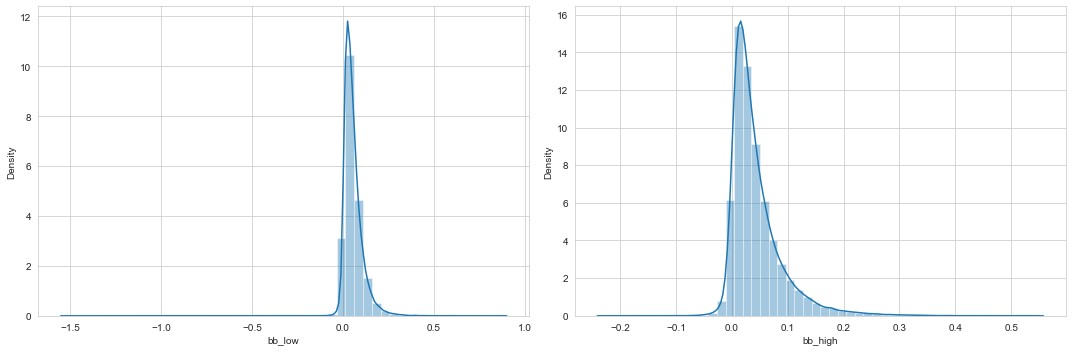

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout()

In [23]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [24]:

prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

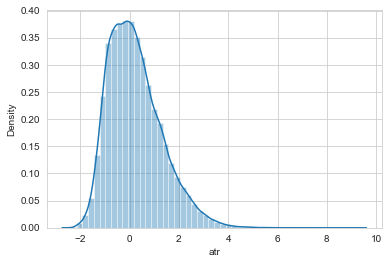

In [25]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

In [26]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [27]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [28]:
prices

open      close        low       high     volume  \
ticker date                                                                
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287700.0   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114300.0   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601500.0   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567600.0   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787500.0   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209585.0   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213951.0   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227325.0   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162070.0   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222040.0   

                     dollar_vol  dollar_vol_rank        rsi   bb_high  \
ticker date                                                             
A      2013-01-02  0.000000e+00           1088.5        NaN       NaN   
       2013-01-03  0.000000e+00           1088.5        NaN       NaN   
       2013-01-04  0.000000e+00           1088.5        NaN       NaN   
       2013-01-07  0.000000e+00           1088.5        NaN       NaN   
       2013-01-08  0.000000e+00           1088.5        NaN       NaN   
...                         ...              ...        ...       ...   
ZUMZ   2017-12-22  1.193000e+07           1288.0  61.077094  0.028426   
       2017-12-26  1.196337e+07           1291.0  63.799097  0.010058   
       2017-12-27  1.178694e+07           1293.0  56.369727  0.040577   
       2017-12-28  1.129021e+07           1300.0  56.757082  0.039229   
       2017-12-29  1.079061e+07           1312.0  52.959469  0.050887   

                     bb_low       atr      macd  
ticker date                                      
A      2013-01-02       NaN       NaN       NaN  
       2013-01-03       NaN       NaN       NaN  
       2013-01-04       NaN       NaN       NaN  
       2013-01-07       NaN       NaN       NaN  
       2013-01-08       NaN       NaN       NaN  
...                     ...       ...       ...  
ZUMZ   2017-12-22  0.086877 -0.419131  0.851425  
       2017-12-26  0.090436 -0.450751  0.889373  
       2017-12-27  0.057586 -0.282948  0.832724  
       2017-12-28  0.059005 -0.449763  0.784419  
       2017-12-29  0.042288 -0.515043  0.696842  

[2904233 rows x 12 columns]

In [32]:
prices.macd.describe()

count    2.826749e+06
mean    -8.681482e-18
std      1.000000e+00
min     -1.050309e+01
25%     -5.648321e-01
50%      1.310692e-02
75%      5.786322e-01
max      8.699844e+00
Name: macd, dtype: float64

In [33]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    2,826,749.0
mean            -0.0
std              1.0
min            -10.5
0.1%            -4.1
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.0
max              8.7
Name: macd, dtype: object

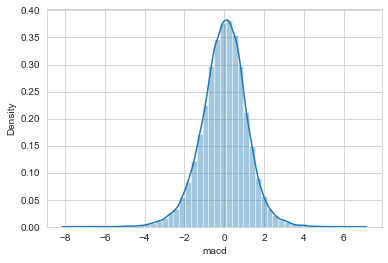

In [34]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

In [35]:
lags = [1, 5, 10, 21, 42, 63]

In [36]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,9.37%
min,-87.62%
0.01%,-33.40%
0.1%,-14.78%
1%,-6.52%
50%,0.04%
99%,6.98%
99.9%,17.03%
99.99%,39.25%
max,"10,280.40%"


In [37]:
q = 0.0001

In [38]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

In [39]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

In [40]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

In [41]:
prices = prices.join(stocks[['sector']])


In [42]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [43]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')


In [44]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [45]:
prices.to_hdf('data.h5', 'model_data')